#  **Testing Gaussian EP on a given RBM**


In [1]:
using Pkg
using Plots
using Revise
using DelimitedFiles
using BenchmarkTools

In [3]:
Pkg.activate("../Sampling/")
using Sampling
Pkg.activate("../../GaussianEP/")
using GaussianEP

  Activating environment at `~/GaussianEP/Sampling/Project.toml`
  Activating environment at `~/GaussianEP/Project.toml`
┌ Info: Precompiling GaussianEP [61ebe778-2184-11e9-3f76-6b275578b029]
└ @ Base loading.jl:1342


In [4]:
# Number of visible and hidden units, Gaussian weigths
N = 10
M = 5
w = randn(N,M)
y = zeros(N+M)
H = [GaussianEP.TermRBM(w,y,1.0)];

In [5]:
μv = 3.0; βv = 5.0;
μh = 5.0; βh = 4.0;

Pv = GaussianEP.GaussianPrior(μv, βv, 0.0) 
Ph = GaussianEP.GaussianPrior(μh, βh, 0.0) 

P0 = vcat([Pv for i = 1:N], [Ph for i = 1:M]);

# Block EP update

In [6]:
@time vstate, hstate, Σ_vh, _ = GaussianEP.block_expectation_propagation(H, P0, nprint = 100);


  9.343727 seconds (11.09 M allocations: 594.633 MiB, 7.73% gc time, 99.97% compilation time)


# (Pv, Ph) = (Gaussian - Gaussian) priors

In [8]:
@time out, _, _ = GaussianEP.expectation_propagation(H, P0, nprint = 100);
#out.state.Σ


  1.435767 seconds (1.24 M allocations: 65.137 MiB, 4.18% gc time, 99.86% compilation time)


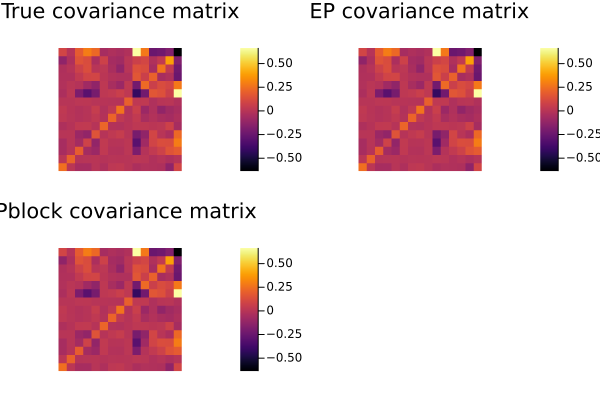

In [9]:
using Plots

Σan = GaussianEP.compute_analytic(w,[Pv for i = 1:N], [Ph for i = 1:M])
p1 = heatmap(Σan, aspect_ratio=1, ticks= :false, showaxis = :false, title="True covariance matrix", titlelocation=:center)
p2 = heatmap(out.state.Σ, aspect_ratio=1, ticks= :false, showaxis =:false, title="EP covariance matrix", titlelocation=:center)
p3 = heatmap(Σ_vh, aspect_ratio=1, ticks= :false, showaxis =:false, title="EPblock covariance matrix", titlelocation=:center)
Plots.plot(p1,p2, p3)

In [10]:
[sum(abs.(Σ_vh - Σan)), sum(abs.(out.state.Σ -Σan))]

2-element Vector{Float64}:
 0.013199288337443426
 0.013199288337444796

# (Pv, Ph) = (Binary - Gaussian) priors

In [11]:
x0v = 0.0; x1v = 1.0; ρ = 0.8;
μh = 0.5; βh = 3.0; 
Pv = GaussianEP.BinaryPrior(x0v, x1v, ρ)
Ph = GaussianEP.GaussianPrior(μh, βh, 0.0)

P0 = vcat([Pv for i = 1:N], [Ph for i = 1:M]);

In [12]:
@time vstate, hstate, Σ_vh, _ = GaussianEP.block_expectation_propagation(H, P0, epsconv = 1e-4, maxiter = 10000, damp = 0.999);

it: 100 Δav: 0.002241919183682217 Δgrad: 0.0
it: 200 Δav: 0.003380970393155547 Δgrad: 0.0
it: 300 Δav: 0.00425258279706453 Δgrad: 0.0
it: 400 Δav: 0.0032894823324842726 Δgrad: 0.0
it: 500 Δav: 0.0026477426260597126 Δgrad: 0.0
it: 600 Δav: 0.0025539966363183897 Δgrad: 0.0
it: 700 Δav: 0.0027391706303343533 Δgrad: 0.0
it: 800 Δav: 0.0036285921801716206 Δgrad: 0.0
it: 900 Δav: 0.006582540108205359 Δgrad: 0.0
it: 1000 Δav: 0.01540414096438436 Δgrad: 0.0
it: 1100 Δav: 0.06896509840064624 Δgrad: 0.0
it: 1200 Δav: 5.442459244240965 Δgrad: 0.0
it: 1300 Δav: 0.04589264745861232 Δgrad: 0.0
it: 1400 Δav: 0.012555096886098127 Δgrad: 0.0
it: 1500 Δav: 0.00572544899007843 Δgrad: 0.0
it: 1600 Δav: 0.0032434756684427413 Δgrad: 0.0
it: 1700 Δav: 0.002071623237606346 Δgrad: 0.0
it: 1800 Δav: 0.0014273215082090118 Δgrad: 0.0
it: 1900 Δav: 0.0010358055061847615 Δgrad: 0.0
it: 2000 Δav: 0.0007804528177217662 Δgrad: 0.0
it: 2100 Δav: 0.0006049086589596797 Δgrad: 0.0
it: 2200 Δav: 0.00047923199728217014 Δgra

In [13]:
@time out, _, _ = GaussianEP.expectation_propagation(H, P0, epsconv = 1e-4, damp = 0.999, maxiter = 10000);
cov_ep = zeros(N,M)
cov_ep_block = zeros(N,M)
for i = 1:N, j = 1:M
	cov_ep[i,j] = out.state.Σ[i,N+j] + out.state.av[i] * out.state.av[N+j]
	cov_ep_block[i,j] = Σ_vh[i,N+j] + vstate.av[i] * hstate.av[j]
end


it: 100 Δav: 0.0022545824293260797 Δgrad: 0.0
it: 200 Δav: 0.003415346827594812 Δgrad: 0.0
it: 300 Δav: 0.004321525008516236 Δgrad: 0.0
it: 400 Δav: 0.0033619961493118744 Δgrad: 0.0
it: 500 Δav: 0.0026716724015631854 Δgrad: 0.0
it: 600 Δav: 0.0025812495076714126 Δgrad: 0.0
it: 700 Δav: 0.0027897465616359973 Δgrad: 0.0
it: 800 Δav: 0.0036080813035693285 Δgrad: 0.0
it: 900 Δav: 0.006532534978204496 Δgrad: 0.0
it: 1000 Δav: 0.015226867242320141 Δgrad: 0.0
it: 1100 Δav: 0.06731231757683975 Δgrad: 0.0
it: 1200 Δav: 6.84249027543482 Δgrad: 0.0
it: 1300 Δav: 0.04681666169134591 Δgrad: 0.0
it: 1400 Δav: 0.01268687404510871 Δgrad: 0.0
it: 1500 Δav: 0.005766238050530781 Δgrad: 0.0
it: 1600 Δav: 0.003261044106658062 Δgrad: 0.0
it: 1700 Δav: 0.0020807196601349 Δgrad: 0.0
it: 1800 Δav: 0.001432618122608531 Δgrad: 0.0
it: 1900 Δav: 0.0010391508750835499 Δgrad: 0.0
it: 2000 Δav: 0.000782695415573631 Δgrad: 0.0
it: 2100 Δav: 0.0006064817979858361 Δgrad: 0.0
it: 2200 Δav: 0.0004803755536415544 Δgrad: 0

In [14]:
[vstate.av out.av[1:N]]

10×2 Matrix{Float64}:
 0.175374   0.175362
 0.148839   0.148837
 0.830268   0.830274
 0.890659   0.890666
 0.57883    0.578813
 0.303054   0.303061
 0.0704837  0.0704806
 0.0456801  0.0456761
 0.17886    0.178861
 0.904495   0.904509

In [15]:
[hstate.av out.av[N+1:end]]

5×2 Matrix{Float64}:
  1.22709     1.2271
 -0.12722    -0.127231
 -0.0176142  -0.0176205
  0.474246    0.474245
 -1.83785    -1.83785

In [16]:
av_an, va_an, cov_an = GaussianEP.compute_analytic(w, [Pv for i = 1:N], [Ph for i = 1:M]);

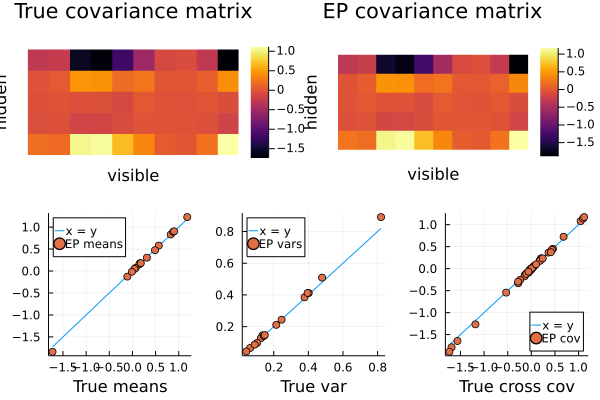

In [17]:
p1 = heatmap(cov_an', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="True covariance matrix", titlelocation=:center)
p2 = heatmap(cov_ep', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="EP covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_an, av_an, label = "x = y") 
p3 = Plots.plot!(av_an, out.av, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel = "True means")
p4 = Plots.plot(va_an, va_an, label = "x = y")
p4 = Plots.plot!(va_an, out.va, seriestype = :scatter, label = "EP vars", legend = :topleft, xlabel = "True var")
p5 = Plots.plot(vec(cov_an), vec(cov_an), label = "x = y")
p5 = Plots.plot!(vec(cov_an), vec(cov_ep), seriestype = :scatter, label = "EP cov", legend = :bottomright, xlabel = "True cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

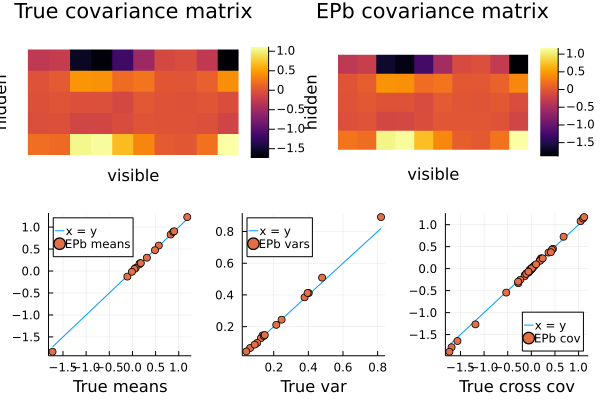

In [18]:
p1 = heatmap(cov_an', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="True covariance matrix", titlelocation=:center)
p2 = heatmap(cov_ep_block', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="EPb covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_an, av_an, label = "x = y") 
p3 = Plots.plot!(av_an, cat(vstate.av, hstate.av, dims=1), seriestype = :scatter, label = "EPb means", legend = :topleft, xlabel = "True means")
p4 = Plots.plot(va_an, va_an, label = "x = y")
p4 = Plots.plot!(va_an, cat(vstate.va, hstate.va, dims=1), seriestype = :scatter, label = "EPb vars", legend = :topleft, xlabel = "True var")
p5 = Plots.plot(vec(cov_an), vec(cov_an), label = "x = y")
p5 = Plots.plot!(vec(cov_an), vec(cov_ep_block), seriestype = :scatter, label = "EPb cov", legend = :bottomright, xlabel = "True cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

In [19]:
Pv = Sampling.BinaryPrior(x0v, x1v, ρ) 
Ph = Sampling.GaussianPrior(μh, βh, 0.0)
P0mc = vcat([Pv for i = 1:N],[Ph for i = 1:M]);

  2.260505 seconds (15.55 M allocations: 1006.996 MiB, 21.72% gc time, 20.57% compilation time)


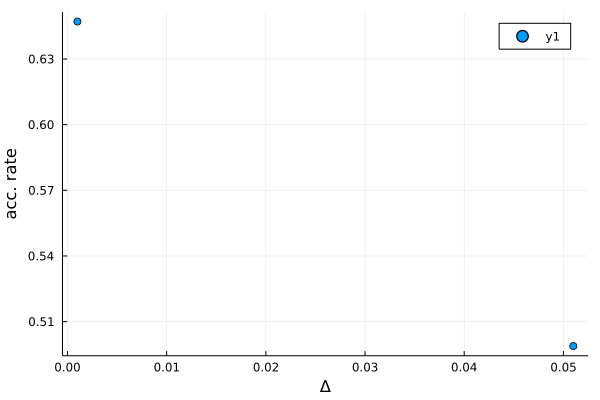

In [20]:
# Get acceptance rate ~ 0.5
Δ_vec = collect(0.001:0.05:0.1)
@time acc_tab = Sampling.MC_Δ_scan(Δ_vec,w,P0mc,10^5)
plot(acc_tab[:,1], acc_tab[:,2], xlabel="Δ", ylabel="acc. rate", seriestype = :scatter)

  0.030496 seconds (82 allocations: 16.007 MiB, 61.57% gc time)


┌ Warning: scale log is unsupported with Plots.GRBackend().  Choose from: [:identity, :log10]
└ @ Plots /home/disat/amuntoni/.julia/packages/Plots/PomtQ/src/args.jl:1649


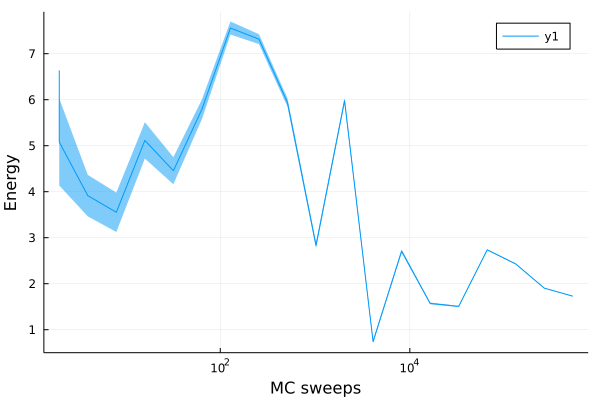

In [25]:
# Get thermalization time

Δ = 0.05
nblocks = 20
mc_energy = Sampling.MC_t_therm(nblocks, w, P0mc, Δ) 
@time bl_tab = Sampling.block_anal(nblocks, mc_energy)

p1 = plot(bl_tab[:,1], bl_tab[:,2], ribbon=bl_tab[:,3],fillalpha=.5, xscale =:log, xlabel="MC sweeps", ylabel="Energy") 
plot(p1)


In [26]:
# Sampling using MCMC
bl_tab = nothing
Nconf = 10^5
Twait = 10^5
@time mc_out = Sampling.MC_sim(w, P0mc, Twait, Δ; N_iter=Nconf);

  2.463477 seconds (15.37 M allocations: 1008.043 MiB, 19.70% gc time, 20.29% compilation time)


In [27]:
# Compute statistics

@time av_mc, va_mc, cov_mc, _ = Sampling.compute_statistics(mc_out, N, M);

  0.231445 seconds (671 allocations: 254.086 MiB, 30.56% gc time)


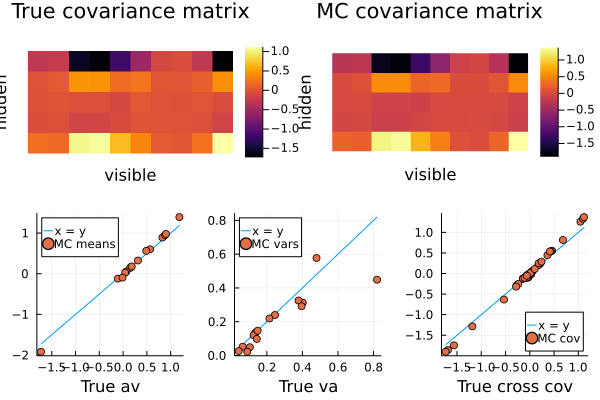

In [28]:
p1 = heatmap(cov_an', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="True covariance matrix", titlelocation=:center)
p2 = heatmap(cov_mc', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="MC covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_an, av_an, label = "x = y") 
p3 = Plots.plot!(av_an, av_mc, seriestype = :scatter, label = "MC means", legend = :topleft, xlabel = "True av")
p4 = Plots.plot(va_an, va_an, label = "x = y")
p4 = Plots.plot!(va_an, va_mc, seriestype = :scatter, label = "MC vars", legend = :topleft, xlabel = "True va")
p5 = Plots.plot(vec(cov_an), vec(cov_an), label = "x = y")
p5 = Plots.plot!(vec(cov_an), vec(cov_mc), seriestype = :scatter, label = "MC cov", legend = :bottomright, xlabel = "True cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

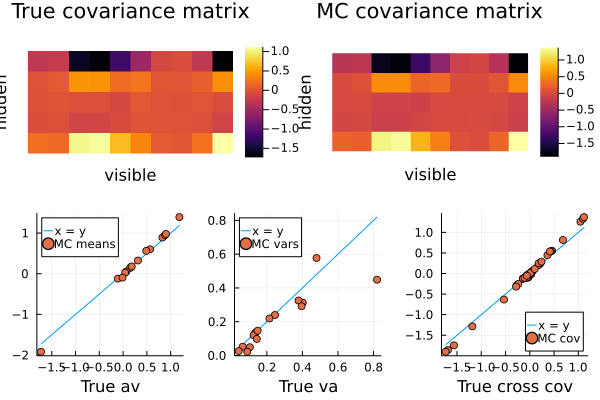

In [ ]:
p1 = heatmap(cov_an', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="True covariance matrix", titlelocation=:center)
p2 = heatmap(cov_mc', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="MC covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_an, av_an, label = "x = y") 
p3 = Plots.plot!(av_an, av_mc, seriestype = :scatter, label = "MC means", legend = :topleft, xlabel = "True av")
p4 = Plots.plot(va_an, va_an, label = "x = y")
p4 = Plots.plot!(va_an, va_mc, seriestype = :scatter, label = "MC vars", legend = :topleft, xlabel = "True va")
p5 = Plots.plot(vec(cov_an), vec(cov_an), label = "x = y")
p5 = Plots.plot!(vec(cov_an), vec(cov_mc), seriestype = :scatter, label = "MC cov", legend = :bottomright, xlabel = "True cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

# (Pv, Ph) = (Gaussian, ReLu) Priors

In [ ]:

# Number of visible and hidden units, Gaussian weigths
N = 100
M = 10
w = randn(N,M)
y = zeros(N+M)
H = [GaussianEP.TermRBM(w,y,1.0)];
γ = 50.0
θ = 1.0
μv = 0.0; βv = 10.0; # βv needs to be large

Pv = GaussianEP.GaussianPrior(μv, βv, 0.0)
Ph = GaussianEP.ReLUPrior(γ, θ, 1e-2, 0.0)

P0 = vcat([Pv for i = 1:N], [Ph for i = 1:M]);

In [ ]:
out = GaussianEP.expectation_propagation(H, P0, nprint = 50, epsconv = 1e-5, maxiter = 100000)

cov_ep = zeros(N,M)
for i = 1:N, j = 1:M
	cov_ep[i,j] = out[1].state.Σ[i,N+j] + out[1].state.av[i] * out[1].state.av[N+j]
end

In [ ]:
γ_m = Ph.γ
θ_m = Ph.θ
println(γ_m, " ", θ_m)

In [ ]:
Pv = Sampling.GaussianPrior(μv, βv, 0.0) 
Ph = Sampling.ReLUPrior(γ_m, θ_m) 

P0mc = vcat([Pv for i=1:N], [Ph for i = 1:M]);

In [ ]:
# Get acceptance rate ~ 0.5
Δ_vec = collect(0.05:0.05:0.9)
acc_tab = Sampling.MC_Δ_scan(Δ_vec,w,P0mc,10^3)
plot(acc_tab[:,1], acc_tab[:,2], xlabel="Δ", ylabel="acc. rate", seriestype = :scatter)

In [ ]:

# Get thermalization time

Δ = 0.8
nblocks = 20
mc_energy = Sampling.MC_t_therm(nblocks, w, P0mc, Δ) 
bl_tab = Sampling.block_anal(nblocks, mc_energy)

p1 = plot(bl_tab[:,1], bl_tab[:,2], ribbon=bl_tab[:,3],fillalpha=.5, xscale =:log) 
plot(p1)

In [ ]:
# Sampling using MCMC

mc_energy = nothing
bl_tab = nothing
mc_out = nothing

Δ = 0.8
Nconf = 5 * 10^5
Twait = 10^4

mc_out = Sampling.MC_sim(w, P0mc, Twait, Δ; N_iter=Nconf);

In [ ]:
# Compute statistics

av_mc, va_mc, cov_mc, _ = Sampling.compute_statistics(mc_out, N, M);

In [ ]:

p1 = heatmap(cov_ep', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="EP covariance matrix", titlelocation=:center)
p2 = heatmap(cov_mc', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="MC covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_mc, av_mc, label = "x = y") 
p3 = Plots.plot!(av_mc, out[1].av, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel = "MC av")
p4 = Plots.plot(va_mc, va_mc, label = "x = y")
p4 = Plots.plot!(va_mc, out[1].va, seriestype = :scatter, label = "EP vars", legend = :topleft, xlabel = "MC va")
p5 = Plots.plot(vec(cov_mc), vec(cov_mc), label = "x = y")
p5 = Plots.plot!(vec(cov_mc), vec(cov_ep), seriestype = :scatter, label = "EP cov", legend = :bottomright, xlabel = "MC cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

# (Pv, Ph) = (SpikeAndSlab, ReLu) priors

In [ ]:

# Number of visible and hidden units, Gaussian weigths
N = 30
M = 15
w = randn(N,M)
y = zeros(N+M)
H = [GaussianEP.TermRBM(w,y,1.0)];
γ = 50.0
ρ = 1.0/21
λ = 50.0
Pv = GaussianEP.SpikeSlabPrior(ρ, λ, 0.0, 1e-3)
Ph = GaussianEP.ReLUPrior(γ, 0.0, 1e-3, 1e-3) 

P0 = vcat([Pv for i =1:N], [Ph for i = 1:M]);


In [ ]:

out = GaussianEP.expectation_propagation(H, P0, epsconv = 1e-5, nprint = 100)

cov_ep = zeros(N,M)
for i = 1:N, j = 1:M
	cov_ep[i,j] = out[1].state.Σ[i,N+j] + out[1].state.av[i] * out[1].state.av[N+j]
end


In [ ]:
γ_m = Ph.γ
θ_m = Ph.θ
λ_m = Pv.λ
println("γ: ",γ_m, " θ: ", θ_m, " λ: ", λ_m)
Pv = Sampling.SpikeSlabPrior(ρ, λ_m) 
Ph = Sampling.ReLUPrior(γ_m, θ_m)
P0mc = vcat([Pv for i=1:N],[Ph for i = 1:M]);

In [ ]:

# Get acceptance rate ~ 0.5
Δ_vec = collect(0.5:0.5:6.0)
acc_tab = Sampling.MC_Δ_scan(Δ_vec,w,P0mc,10^3)
plot(acc_tab[:,1], acc_tab[:,2], xlabel="Δ", ylabel="acc. rate", seriestype = :scatter)

In [ ]:
# Get thermalization time

Δ = 3.5
nblocks = 18
mc_energy = Sampling.MC_t_therm(nblocks, w, P0mc, Δ) 
bl_tab = Sampling.block_anal(nblocks, mc_energy)

p1 = plot(bl_tab[:,1], bl_tab[:,2], ribbon=bl_tab[:,3],fillalpha=.5, xscale =:log) 
plot(p1)

In [ ]:
# Sampling using MCMC
mc_energy = nothing
bl_tab = nothing
mc_out = nothing

Δ = 3.5
Nconf = 5*10^6
Twait = 10^5

@time mc_out = Sampling.MC_sim(w, P0mc, Twait, Δ; N_iter=Nconf);

In [ ]:
# Compute statistics

@time av_mc, va_mc, cov_mc, _ = Sampling.compute_statistics(mc_out, N, M);

In [ ]:
p1 = heatmap(cov_ep', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="EP covariance matrix", titlelocation=:center)
p2 = heatmap(cov_mc', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="MC covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_mc, av_mc, label = "x = y") 
p3 = Plots.plot!(av_mc, out[1].av, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel = "MC av")
p4 = Plots.plot(va_mc, va_mc, label = "x = y")
p4 = Plots.plot!(va_mc, out[1].va, seriestype = :scatter, label = "EP vars", legend = :topleft, xlabel = "MC va")
p5 = Plots.plot(vec(cov_mc), vec(cov_mc), label = "x = y")
p5 = Plots.plot!(vec(cov_mc), vec(cov_ep), seriestype = :scatter, label = "EP cov", legend = :bottomright, xlabel = "MC cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)

# (Pv, Ph) = (Gaussian, Spike and Slab)

In [ ]:

# Number of visible and hidden units, Gaussian weigths
N = 30
M = 15
w = randn(N,M)
y = zeros(N+M)
H = [GaussianEP.TermRBM(w,y,1.0)];
ρ = 0.2
λ = 20.0
μv = 0.5
βv = 50.0

Ph = GaussianEP.SpikeSlabPrior(ρ, λ)
Pv = GaussianEP.GaussianPrior(μv, βv, 0.0) 

P0 = vcat([Pv for i =1:N], [Ph for i = 1:M]);


In [ ]:
out = GaussianEP.expectation_propagation(H, P0, nprint = 100);

cov_ep = zeros(N,M)
for i = 1:N, j = 1:M
	cov_ep[i,j] = out[1].state.Σ[i,N+j] + out[1].state.av[i] * out[1].state.av[N+j]
end

In [ ]:
Ph = Sampling.SpikeSlabPrior(ρ, λ)
Pv = Sampling.GaussianPrior(μv, βv, 0.0)
P0mc = vcat([Pv for i=1:N],[Ph for i = 1:M]);

In [ ]:

# Get acceptance rate ~ 0.5
Δ_vec = collect(0.1:0.1:1.2)
acc_tab = Sampling.MC_Δ_scan(Δ_vec,w,P0mc,10^3)
plot(acc_tab[:,1], acc_tab[:,2], xlabel="Δ", ylabel="acc. rate", seriestype = :scatter)

In [ ]:
# Get thermalization time

Δ = 0.5
nblocks = 15
mc_energy = Sampling.MC_t_therm(nblocks, w, P0mc, Δ) 
bl_tab = Sampling.block_anal(nblocks, mc_energy)

p1 = plot(bl_tab[:,1], bl_tab[:,2], ribbon=bl_tab[:,3],fillalpha=.5, xscale =:log) 
plot(p1)

In [ ]:

# Sampling using MCMC
mc_energy = nothing
bl_tab = nothing
mc_out = nothing

Nconf = 5*10^6
Twait = 10^5

mc_out = Sampling.MC_sim(w, P0mc, Twait, Δ; N_iter=Nconf);

In [ ]:
# Compute statistics

av_mc, va_mc, cov_mc = Sampling.compute_statistics(mc_out, N, M);

In [ ]:
p1 = heatmap(cov_ep', aspect_ratio=1, ticks= :false, showaxis = :false, xlabel = "visible", ylabel = "hidden" ,title="EP covariance matrix", titlelocation=:center)
p2 = heatmap(cov_mc', aspect_ratio=1, ticks= :false, xlabel = "visible", ylabel = "hidden", showaxis =:false,  title="MC covariance matrix", titlelocation=:center)
p3 = Plots.plot(av_mc, av_mc, label = "x = y") 
p3 = Plots.plot!(av_mc, out[1].av, seriestype = :scatter, label = "EP means", legend = :topleft, xlabel = "MC av")
p4 = Plots.plot(va_mc, va_mc, label = "x = y")
p4 = Plots.plot!(va_mc, out[1].va, seriestype = :scatter, label = "EP vars", legend = :topleft, xlabel = "MC va")
p5 = Plots.plot(vec(cov_mc), vec(cov_mc), label = "x = y")
p5 = Plots.plot!(vec(cov_mc), vec(cov_ep), seriestype = :scatter, label = "EP cov", legend = :bottomright, xlabel = "MC cross cov")
l = @layout [a b; c d e]
Plots.plot(p1,p2,p3, p4, p5, layout = l)